In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Importing the dataset

In [2]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


# Useful functions definition

In [3]:
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    # Creating a StandardScaler object
    scaler = StandardScaler()

    # Fitting the scaler to the data and transforming it
    df_scaled = scaler.fit_transform(df_to_scale)

    # Creating a new DataFrame with the scaled data
    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    # Adding the 'profile_id' column back to the scaled DataFrame
    df_scaled['profile_id'] = profile_id

    return df_scaled


In [4]:

def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    """
    Adds multiple exponentially weighted average columns for each original numeric column in the DataFrame 
    for each span value, grouped by 'profile_id'. New features are created only for the original columns.

    :param df: The DataFrame to which the EWA columns will be added.
    :param spans: A list of span values for the EWA calculation.
    :param exclude_columns: A list of column names to be excluded from the EWA calculation.
    :return: DataFrame with new EWA columns added for each span and each original numeric column.
    """
    # Ensure 'profile_id' is not in the exclude_columns
    exclude_columns = set(exclude_columns) | {'profile_id'}

    # List of original columns to apply EWA
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            # Define the column name for the EWA feature
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df


# Feature engineering

First of all, we're gonna add 4 EWA features to each existing feature in the dataset.

In [5]:
exclude_columns = ['stator_winding']

spans= [600, 1200, 2400, 4800]

df_span = add_ewa_features_by_profile_id(df, spans, exclude_columns)

df_span.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_2400,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,...,18.316547,18.316547,19.850691,19.850691,19.850691,19.850691,0.187101,0.187101,0.187101,0.187101
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,...,18.316546,18.316547,19.850691,19.850691,19.850691,19.850691,0.187295,0.187198,0.187149,0.187125
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,...,18.316554,18.316551,19.850691,19.850691,19.850691,19.850691,0.187259,0.187180,0.187141,0.187121
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,...,18.316566,18.316557,19.850691,19.850691,19.850691,19.850691,0.187429,0.187265,0.187183,0.187142
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,...,18.316575,18.316561,19.850690,19.850691,19.850691,19.850691,0.187498,0.187300,0.187201,0.187151


Now we're gonna normalize the dataset

In [6]:
df_norm = apply_z_score_normalization_except_profile_id(df_span)

df_norm.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800,profile_id
0,-1.238979,-0.799812,-1.648158,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477593,-0.513204,-0.556474,-0.610569,17
1,-1.236150,-0.799197,-1.647959,0.393521,-1.681047,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477590,-0.513202,-0.556473,-0.610569,17
2,-1.238757,-0.798729,-1.648064,0.392464,-1.681078,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477590,-0.513203,-0.556473,-0.610569,17
3,-1.236180,-0.798417,-1.648285,0.393356,-1.681146,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,...,-1.591996,-2.452978,-2.433786,-2.395423,-2.325321,-0.477587,-0.513201,-0.556472,-0.610568,17
4,-1.239442,-0.797432,-1.648303,0.393101,-1.681195,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,...,-1.591996,-2.452978,-2.433787,-2.395423,-2.325321,-0.477586,-0.513201,-0.556472,-0.610568,17


In [7]:
#function to trim sessions to an appropriate size
def preprocess(df, sessions_id, seq_len):
    target="stator_winding"
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]

        #because the sequences based on the profile_id are not all the same lenghts, it takes the longest number of 
        #timestamps that is divisible for the seq_len that will be passed to our model

        #for each sequences we will lost a little bit of the dataset ( no more than the sequence_length = 100)
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

In [20]:
#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first = True, bidirectional = False)
        self.fc = nn.Linear(h_size, out_size)
             
    def forward(self, x, h0=None, c0=None):
        if h0 is None and c0 is None:
            h0 = torch.zeros(self.n_layers, x.size(0), self.h_size)
            c0 = torch.zeros(self.n_layers, x.size(0), self.h_size)
        
        out, (hn, cn) = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out, (hn, cn)

In [21]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100

ids = [20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]
sessions = preprocess(df_norm, ids, seq_len)

#create an lstm instance
model = NET(55, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(55, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [22]:
def print_model_size(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([p.numel() for p in model_parameters])
    print(f'The model has {params:,} trainable parameters')

In [23]:
print_model_size(model)

The model has 9,541 trainable parameters


Epoch [1/50], Loss: 0.4083
Epoch [2/50], Loss: 0.1163
Epoch [3/50], Loss: 0.0598
Epoch [4/50], Loss: 0.0523
Epoch [5/50], Loss: 0.0453
Epoch [6/50], Loss: 0.0393
Epoch [7/50], Loss: 0.0380
Epoch [8/50], Loss: 0.0330
Epoch [9/50], Loss: 0.0297
Epoch [10/50], Loss: 0.0271
Epoch [11/50], Loss: 0.0249
Epoch [12/50], Loss: 0.0233
Epoch [13/50], Loss: 0.0215
Epoch [14/50], Loss: 0.0200
Epoch [15/50], Loss: 0.0187
Epoch [16/50], Loss: 0.0177
Epoch [17/50], Loss: 0.0168
Epoch [18/50], Loss: 0.0159
Epoch [19/50], Loss: 0.0151
Epoch [20/50], Loss: 0.0144
Epoch [21/50], Loss: 0.0138
Epoch [22/50], Loss: 0.0132
Epoch [23/50], Loss: 0.0127
Epoch [24/50], Loss: 0.0122
Epoch [25/50], Loss: 0.0117
Epoch [26/50], Loss: 0.0114
Epoch [27/50], Loss: 0.0117
Epoch [28/50], Loss: 0.0121
Epoch [29/50], Loss: 0.0110
Epoch [30/50], Loss: 0.0095
Epoch [31/50], Loss: 0.0092
Epoch [32/50], Loss: 0.0194
Epoch [33/50], Loss: 0.0120
Epoch [34/50], Loss: 0.0178
Epoch [35/50], Loss: 0.0097
Epoch [36/50], Loss: 0.0126
E

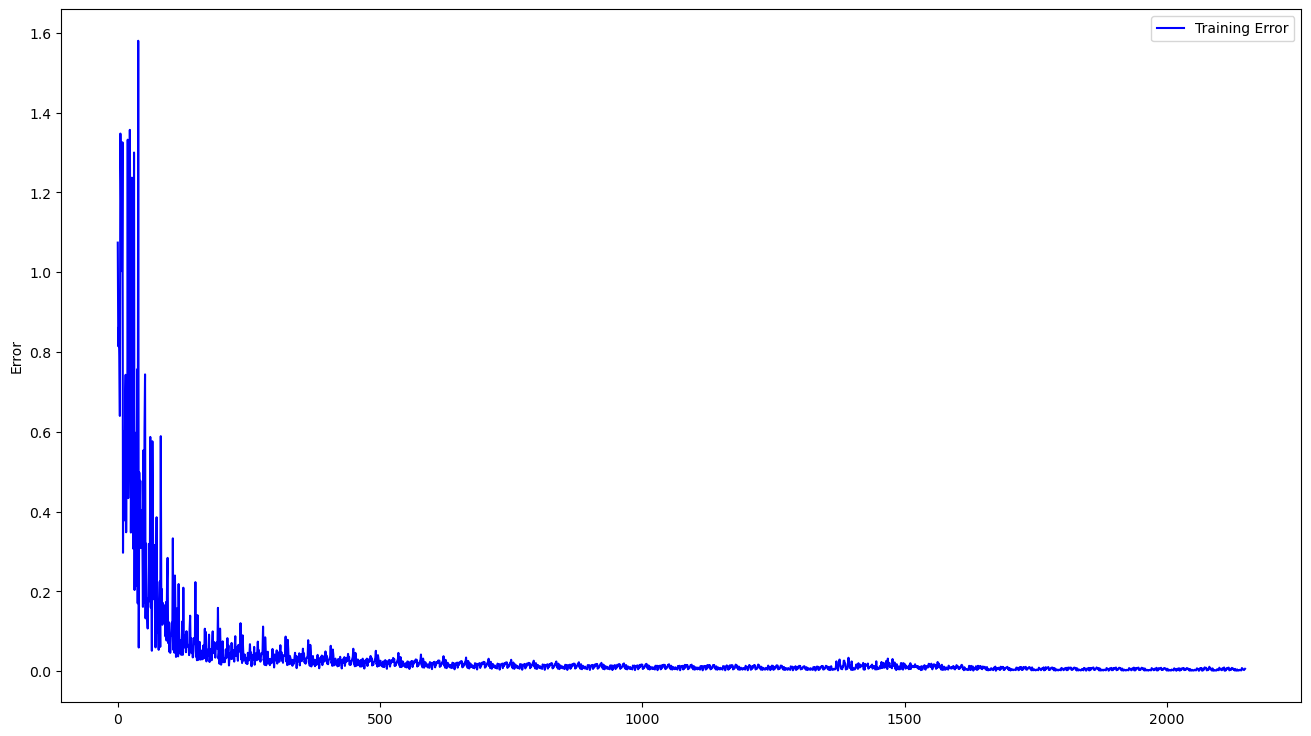

'n_epochs = 50\n\n#train model\ntrain_losses = []\n\nmodel.train()\nfor e in range(n_epochs):\n    for X, y in sessions:\n        optimizer.zero_grad()\n        out = model.forward(X.view(-1, seq_len, 55))\n        loss = criterion(out, y.view(-1, seq_len, 1))\n        \n        loss.backward()\n        optimizer.step()\n        train_losses.append(loss.detach().numpy())\n    \n    print(f\'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}\')\n    \n#print training error\nplt.rcParams["figure.figsize"] = [16, 9]\nplt.plot(train_losses, \'b\', label=\'Training Error\')\nplt.legend(loc=\'upper right\')\nplt.ylabel(\'Error\')\nplt.show()'

In [24]:
n_epochs = 50

# train model
train_losses = []

model.train()
for e in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        
        # Only take the output tensor, not the hidden states
        out, _ = model(X.view(-1, seq_len, 55))  # Assume the model.forward() returns output, (h_n, c_n)
        
        # Ensure the output is the right shape for the criterion
        loss = criterion(out.view(-1), y.view(-1))  # Flatten both output and target tensors
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())  # No need to call .detach().numpy() if you're only storing the item
        
    print(f'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}')

# print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()



'''n_epochs = 50

#train model
train_losses = []

model.train()
for e in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, 55))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()'''

In [25]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import torch

# Number of splits for cross-validation
n_splits = 5

# Prepare the full dataset
full_ids = [20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]
all_sessions = preprocess(df_norm, full_ids, seq_len)

# Initialize cross-validator
kf = KFold(n_splits=n_splits)

# Store the validation scores
val_scores = []

for train_index, test_index in kf.split(all_sessions):
    # Split sessions into training and testing
    train_sessions = [all_sessions[i] for i in train_index]
    test_sessions = [all_sessions[i] for i in test_index]

    # Initialize a new model instance
    model = NET(55, 30, 2, 1)

    # Initialize optimizer and criterion here
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Train the model
    model.train()
    for e in range(n_epochs):
        for X, y in train_sessions:
            optimizer.zero_grad()
            out, _ = model(X.view(-1, seq_len, 55))
            loss = criterion(out.view(-1), y.view(-1))
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_sessions:
            out, _ = model(X_test.view(-1, seq_len, 55))
            loss = criterion(out.view(-1), y_test.view(-1))
            val_scores.append(loss.item())

# Calculate the average validation score
avg_val_score = np.mean(val_scores)
print(f'Average Validation Score: {avg_val_score}')

# Plotting the validation scores
plt.figure(figsize=[16,9])
plt.plot(val_scores, 'r', label='Validation Error per Fold')
plt.axhline(y=avg_val_score, color='g', linestyle='-', label='Average Validation Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.title('Cross-Validation Results')
plt.show()


KeyboardInterrupt: 

In [26]:
#Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


In [27]:
test_ids = [x for x in unique_values if x not in ids]
print(test_ids)

[5, 7, 19, 23, 11, 10, 24, 75, 50, 49, 59, 54, 57, 51, 55, 61, 64, 72, 43, 47, 67, 52, 60, 46, 78, 71]


[5, 7, 19, 23, 11, 10, 24, 75, 50, 49, 59, 54, 57, 51, 55, 61, 64, 72, 43, 47, 67, 52, 60, 46, 78, 71]


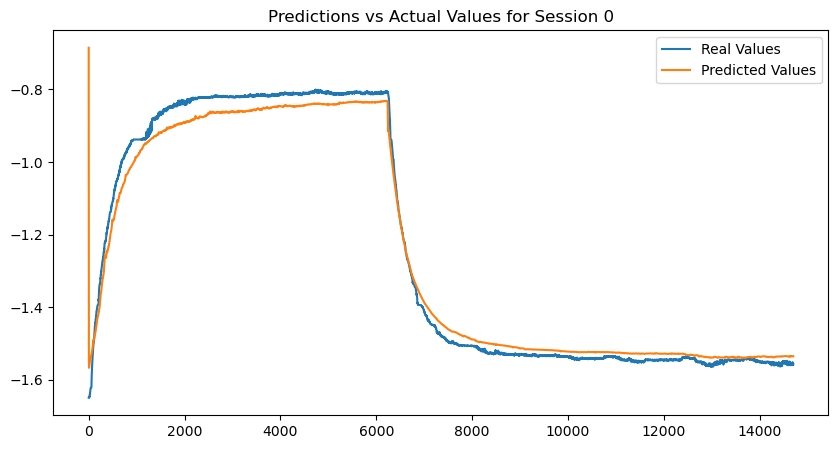

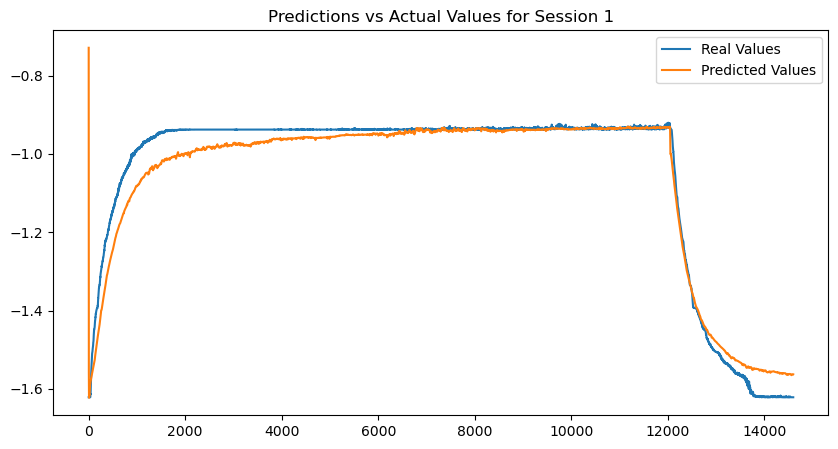

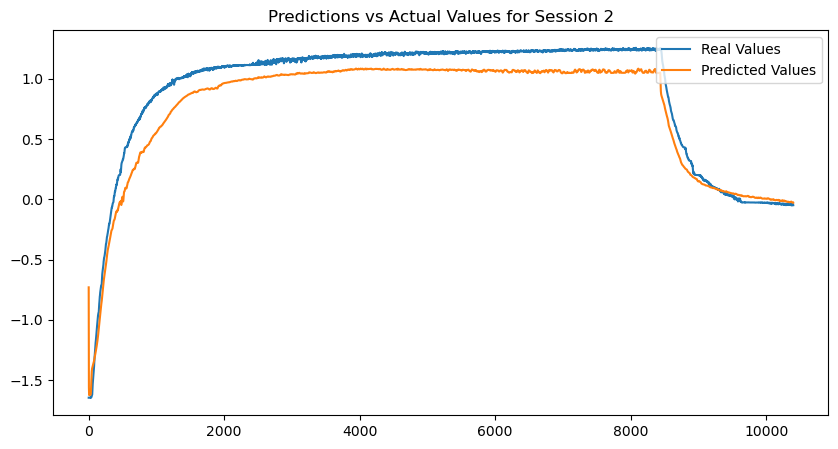

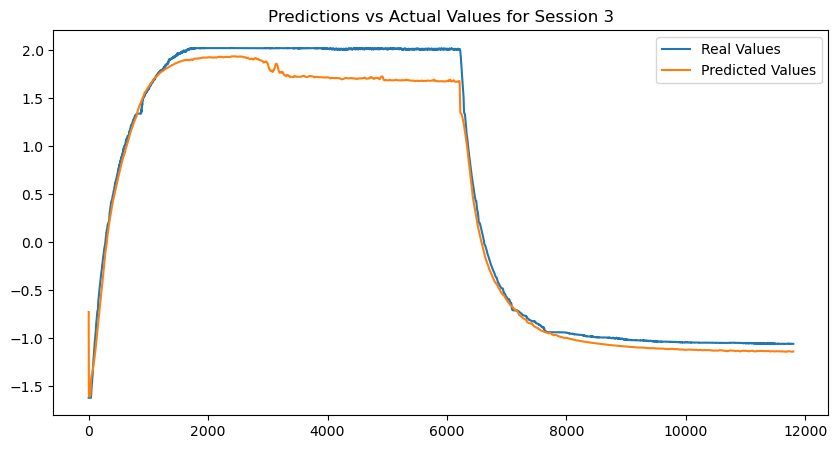

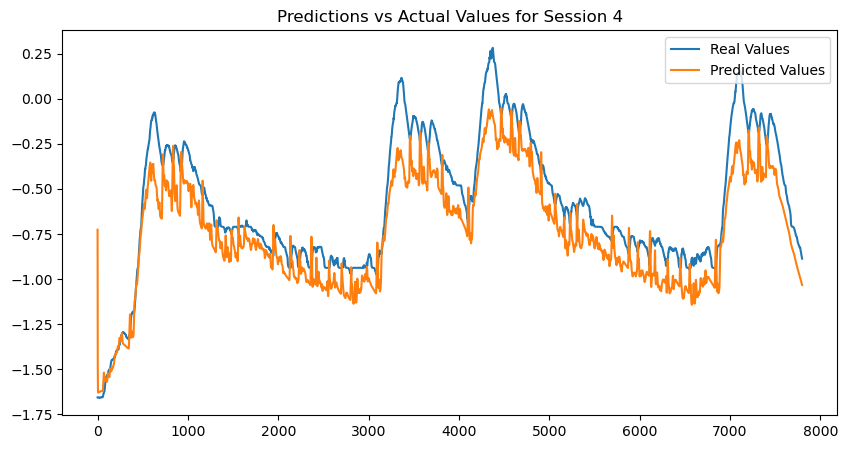

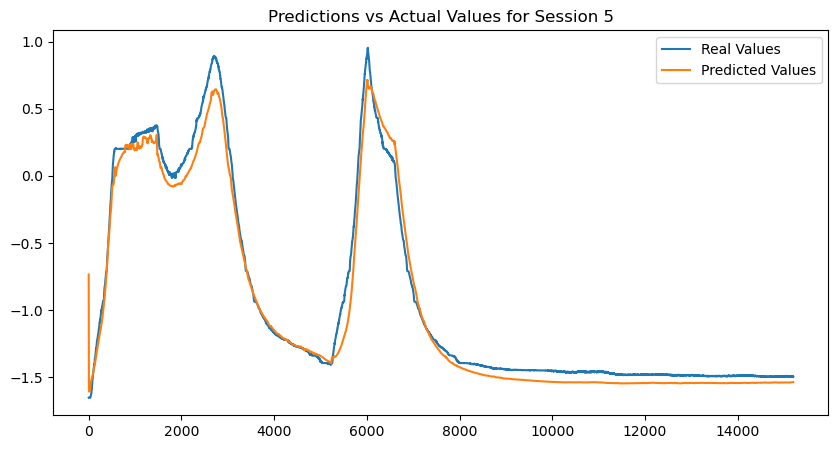

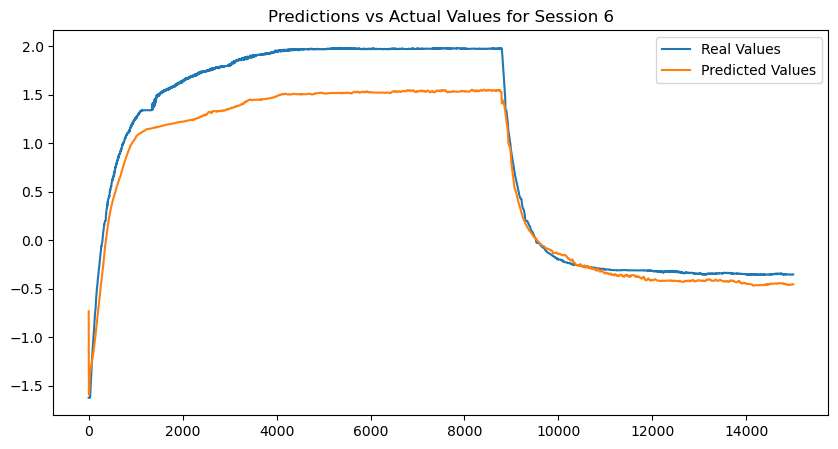

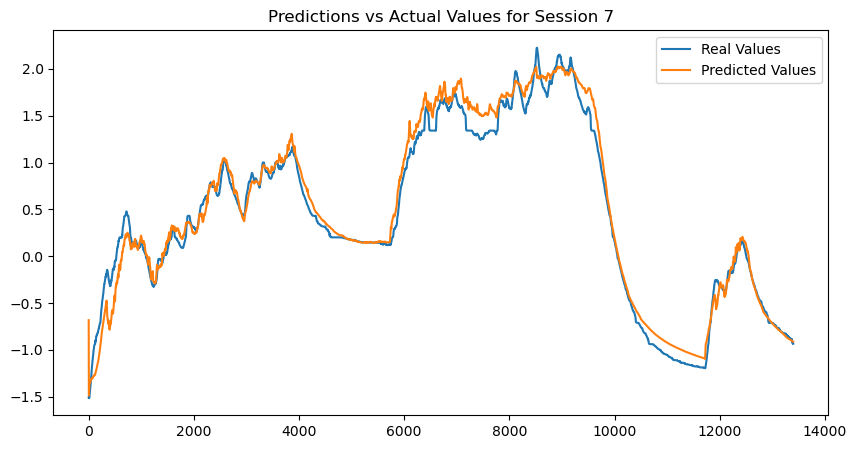

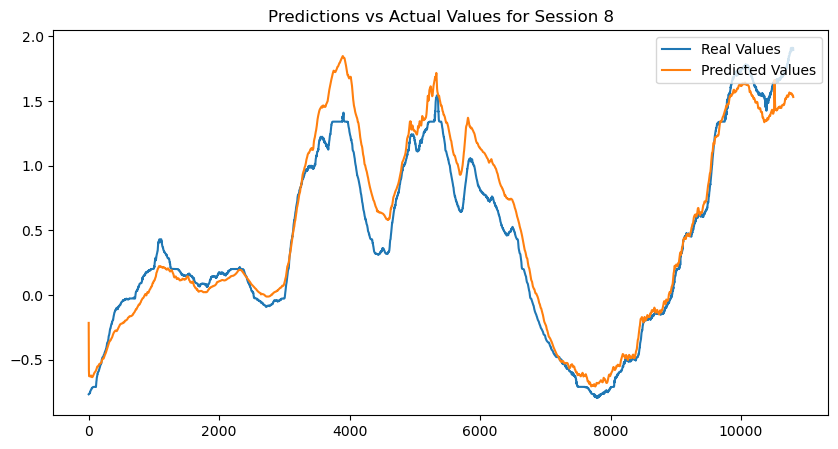

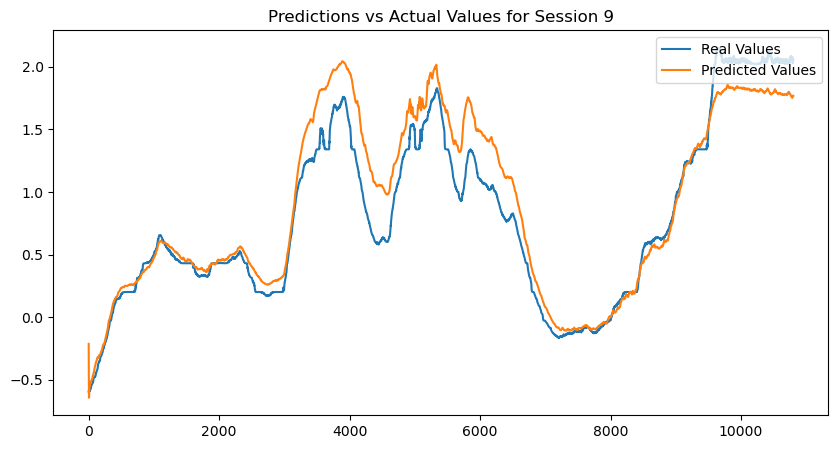

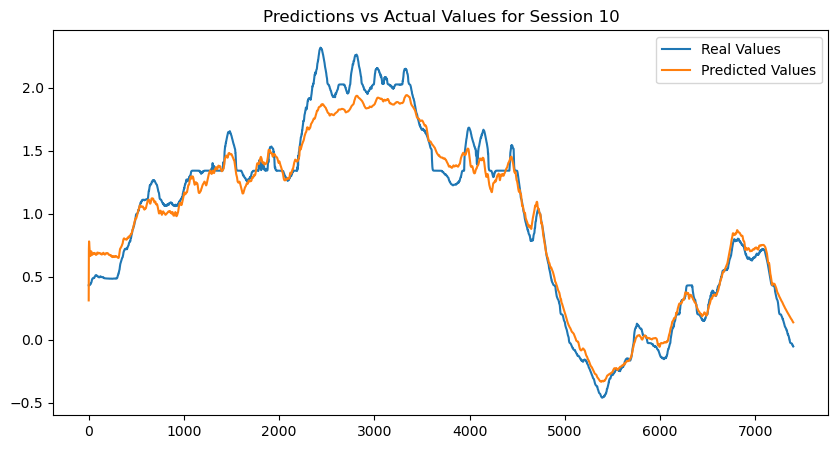

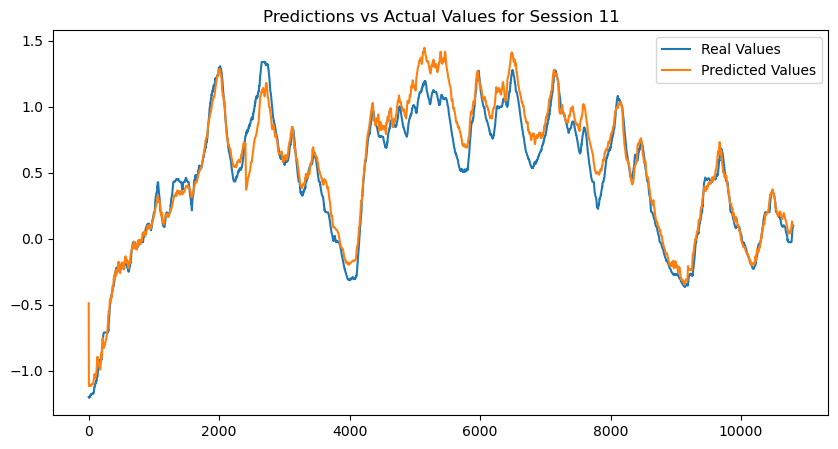

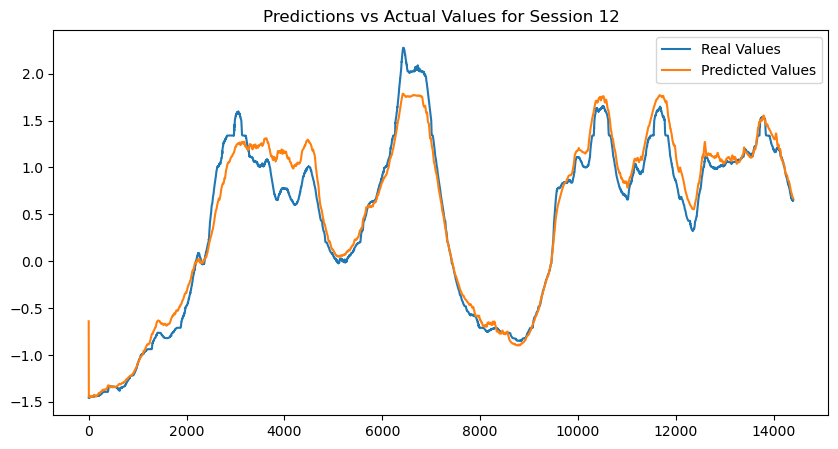

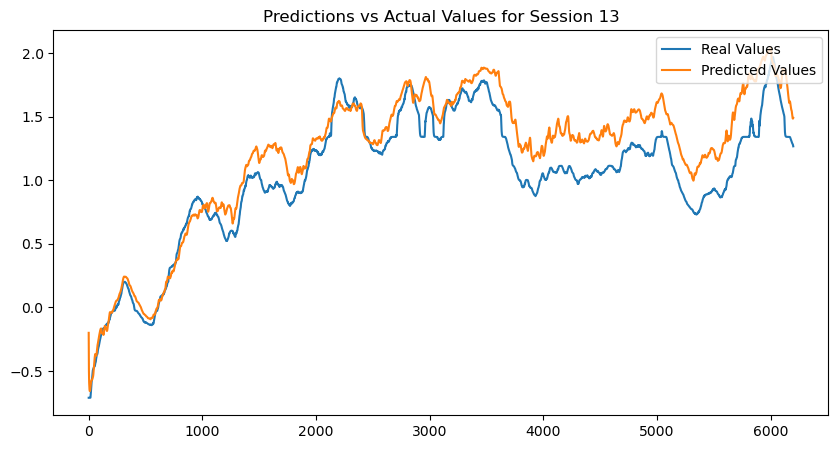

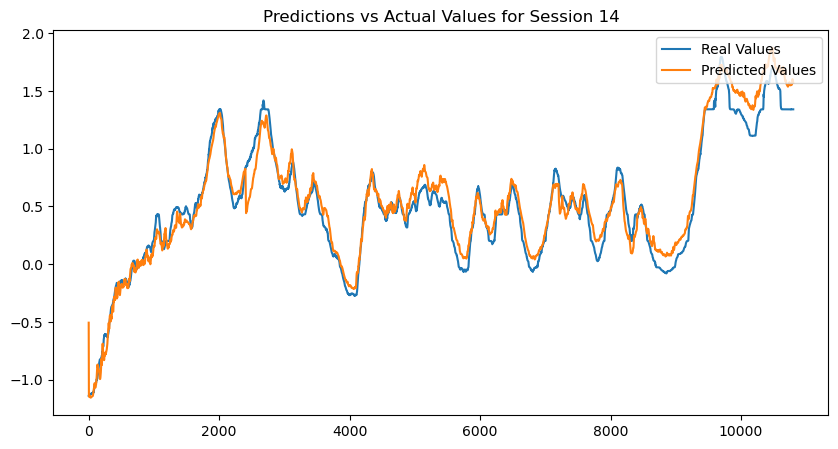

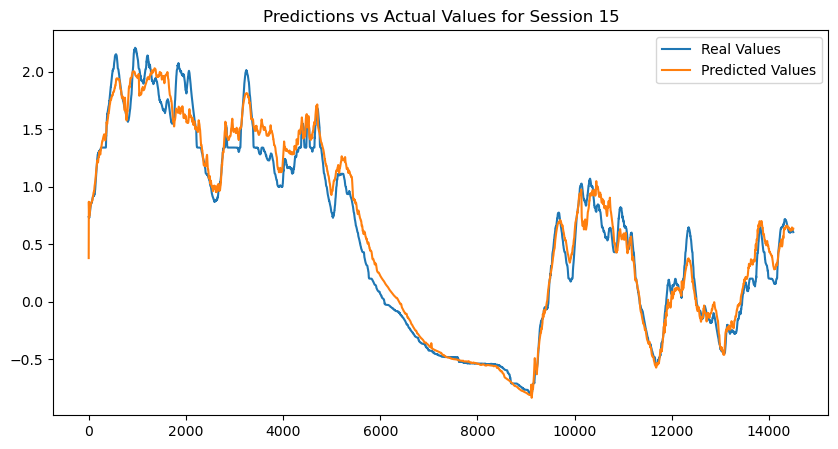

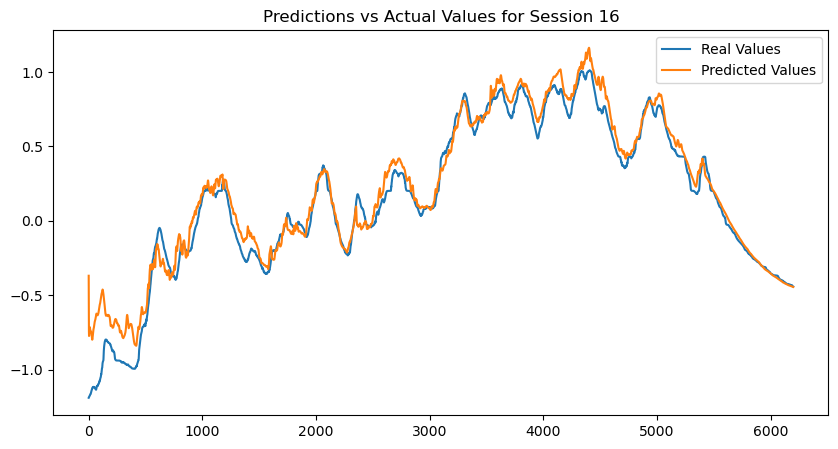

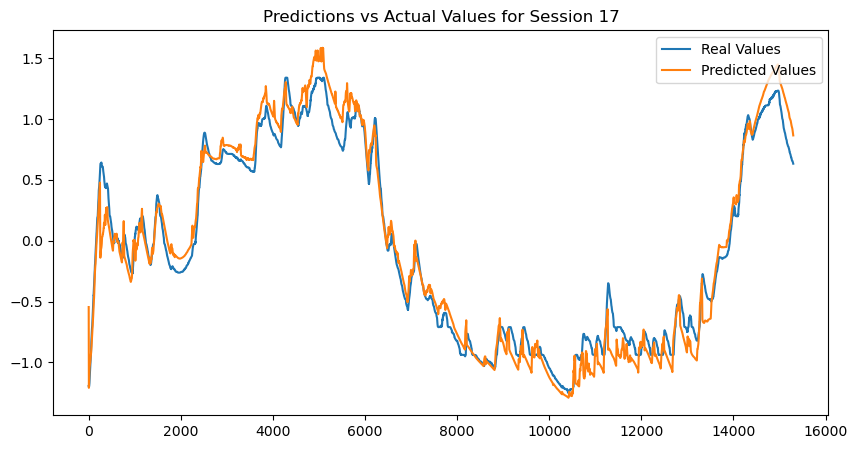

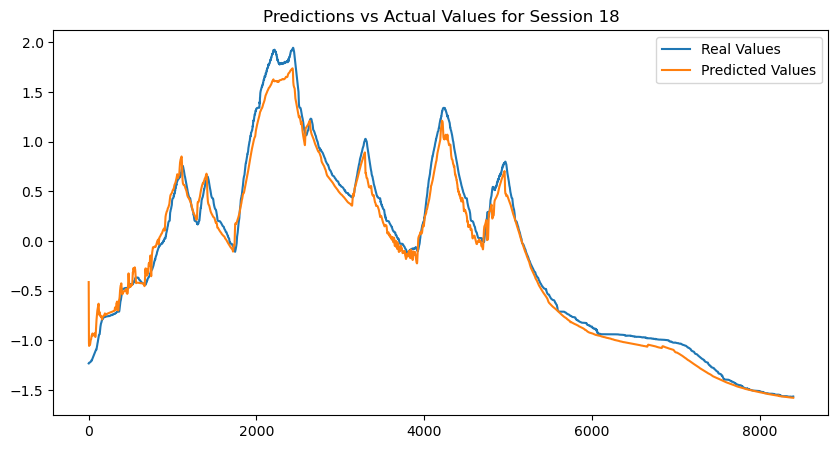

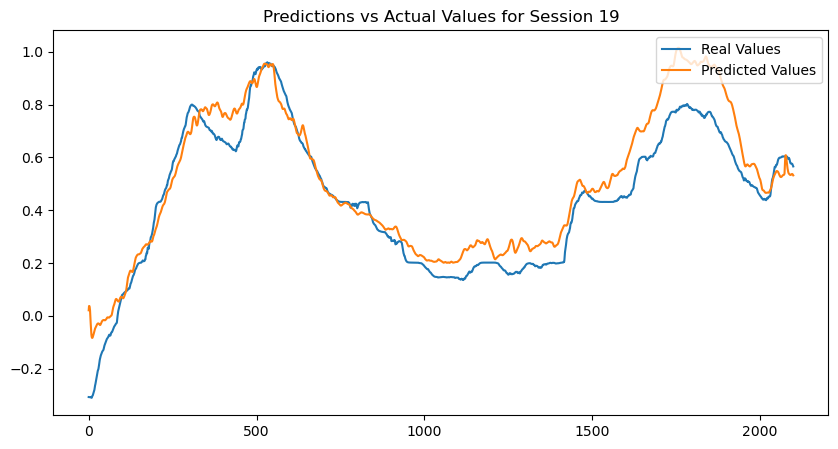

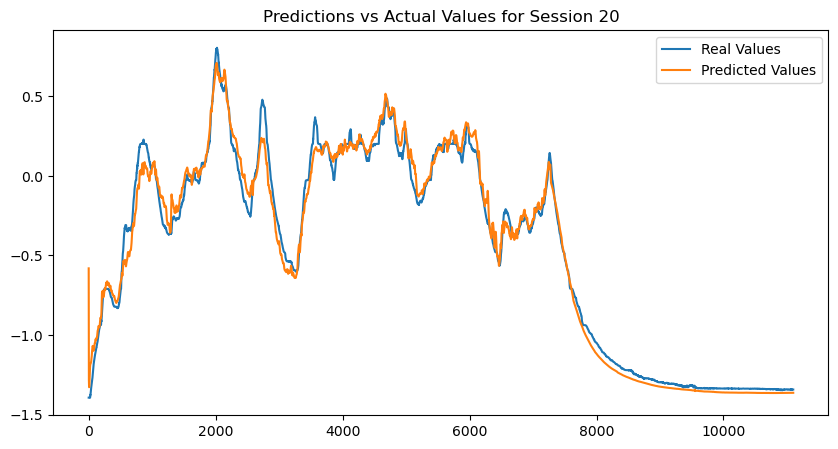

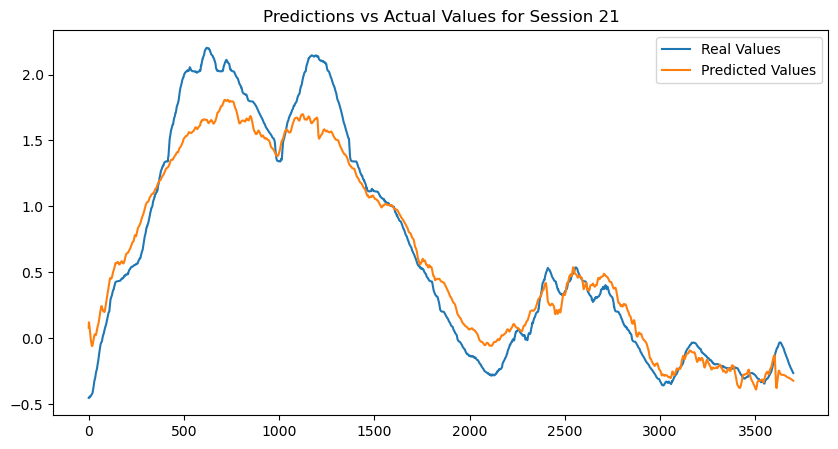

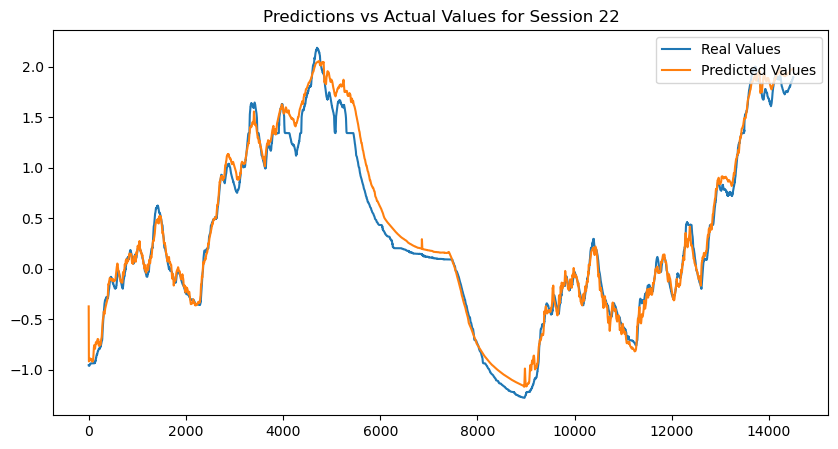

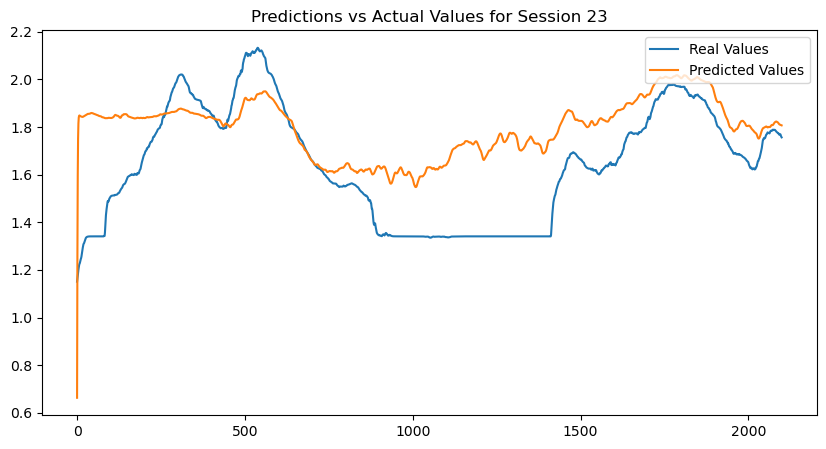

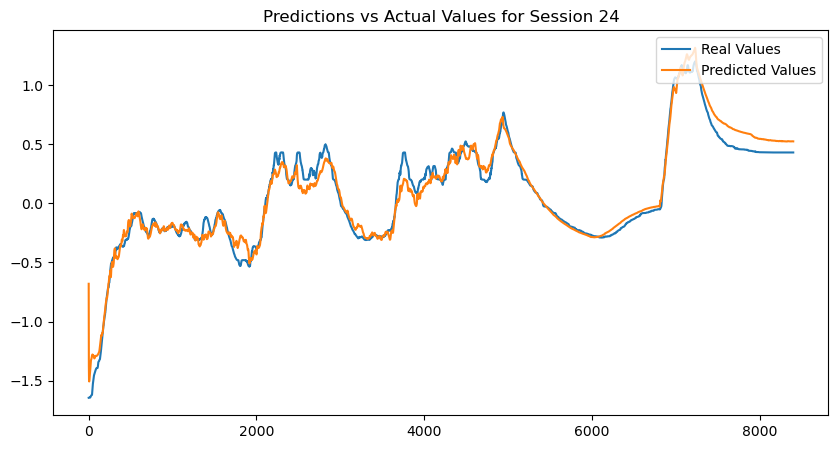

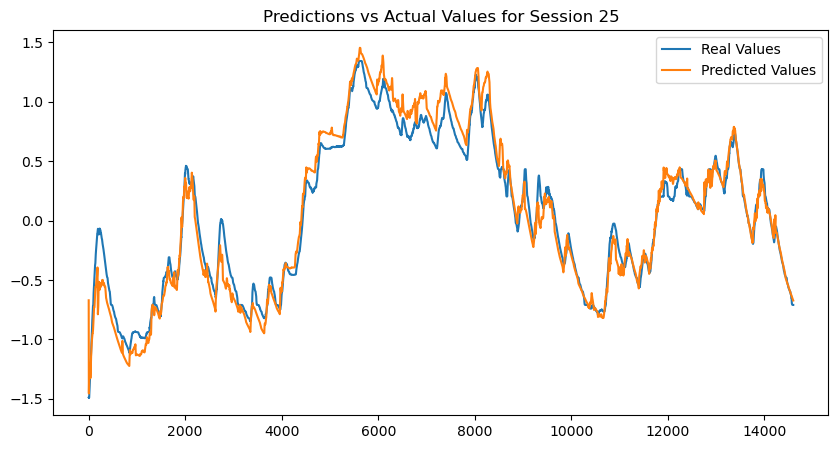

In [28]:
test_ids = [x for x in unique_values if x not in ids]
print(test_ids)

test_sessions = preprocess(df_norm, test_ids, seq_len)

model.eval()
hidden_state = None
cell_state = None

for session_id, (X_test, y_test) in enumerate(test_sessions):
    # Assume that the hidden state is reset at the start of each session
    hidden_state = None
    cell_state = None
    
    predictions = []
    # Make sure the final batch is handled correctly
    for i in range(0, X_test.size(0), seq_len):
        X_batch = X_test[i:min(i+seq_len, X_test.size(0))]  # Handle the last batch
        
        # Forward pass through the model
        out, (hidden_state, cell_state) = model(X_batch.unsqueeze(0), hidden_state, cell_state)
        
        # Detach the hidden state and cell state to prevent backpropagation through them
        hidden_state = hidden_state.detach()
        cell_state = cell_state.detach()
        
        predictions.append(out.view(-1).detach().numpy())

    # Concatenate predictions and compare with actual values
    pred = np.concatenate(predictions)
    real = y_test.numpy()  # Flatten all real values

    # Plot the predictions and actual values for this session
    plt.figure(figsize=(10, 5))
    plt.plot(real, label="Real Values")
    plt.plot(pred, label="Predicted Values")
    plt.legend(loc='upper right')
    plt.title(f"Predictions vs Actual Values for Session {session_id}")
    plt.show()


In [18]:
test_ids = [x for x in unique_values if x not in ids]
print(test_ids)

# Preprocess the test data
test_sessions = preprocess(df_norm, test_ids, seq_len)

# Evaluate the model on the preprocessed test data
model.eval()

for session_id, (X_test, y_test) in enumerate(test_sessions):
    # Get the model's predictions for the entire session
    out = model(X_test.view(-1, seq_len, 55))
    
    # Reshape the outputs and the targets to a flat array
    pred = out.view(-1).detach().numpy()  # Flatten all predictions
    real = y_test.view(-1).numpy()        # Flatten all real values
    
    # Compute the loss for the entire session
    loss = criterion(out, y_test.view(-1, seq_len, 1))
    print(f"Loss for session {session_id}: " + str(loss.item()))

    # Plot the predictions and actual values for this session
    plt.figure(figsize=(10, 5))
    plt.plot(real, label="Real Values")
    plt.plot(pred, label="Predicted Values")
    plt.legend(loc='upper right')
    plt.title(f"Predictions vs Actual Values for Session {session_id}")
    plt.show()




[5, 7, 19, 23, 11, 10, 24, 75, 50, 49, 59, 54, 57, 51, 55, 61, 64, 72, 43, 47, 67, 52, 60, 46, 78, 71]


AttributeError: 'tuple' object has no attribute 'view'